# LSTM Travel Time + Speed Prediction - N103.0

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
traffic = pd.read_csv('../db.csv', parse_dates = ["timeStamp"])
traffic.head(10)

,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,roadName,roadClosure,timeStamp
0,64,64,21,21,N103.1,False,2021-04-26 18:11:34
1,34,43,49,39,N103.0,False,2021-04-27 14:53:37
2,64,64,21,21,N103.1,False,2021-04-27 14:53:49
3,51,51,37,37,N103.2,False,2021-04-27 14:54:00
4,74,74,21,21,N101.0,False,2021-04-27 14:54:12
5,33,43,51,39,N103.0,False,2021-04-27 14:57:10
6,64,64,21,21,N103.1,False,2021-04-27 14:57:22
7,39,50,49,38,N103.2,False,2021-04-27 14:57:33
8,74,74,21,21,N101.0,False,2021-04-27 14:57:45
9,52,67,28,21,N101.1,False,2021-04-27 14:57:57


In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294475 entries, 0 to 294474
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   currentSpeed        294475 non-null  int64         
 1   freeFlowSpeed       294475 non-null  int64         
 2   currentTravelTime   294475 non-null  int64         
 3   freeFlowTravelTime  294475 non-null  int64         
 4   roadName            294475 non-null  object        
 5   roadClosure         294475 non-null  bool          
 6   timeStamp           294475 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(4), object(1)
memory usage: 13.8+ MB


In [4]:
print(traffic['roadName'].unique())

['N103.1' 'N103.0' 'N103.2' 'N101.0' 'N101.1' 'N101.2' 'N101.3' 'N101.4'
 'N101.5' 'Cent.0' 'Cent.1' 'Cent.2' 'Cent.3' 'Cent.4']


### Filter Roads

In [5]:
traffic = traffic[(traffic['roadName'] == 'N103.0')]

### Drop unwanted columns 

In [6]:
traffic = traffic.drop(columns = ['roadClosure', 'freeFlowTravelTime', 'freeFlowSpeed', 'roadName'])

### Remove incomplete days

In [7]:
tfc = traffic[(traffic['timeStamp'].dt.day != 26) 
                        & (traffic['timeStamp'].dt.day != 27) 
                        & (traffic['timeStamp'].dt.day != 3)]

### Treat Date and Time

In [8]:
tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")

<ipython-input-8-7e39a034e481>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")


In [9]:
tfc

,currentSpeed,currentTravelTime,timeStamp
6390,44,38,2021042800
6404,44,38,2021042800
6418,44,38,2021042800
6432,44,38,2021042800
6446,44,38,2021042800
...,...,...,...
294415,44,38,2021051509
294429,44,38,2021051509
294443,44,38,2021051509
294457,44,38,2021051509


In [10]:
traffic_by_date = tfc.groupby(['timeStamp'])
traffic_by_date_mean = traffic_by_date.mean()
traffic_by_date_mean

,currentSpeed,currentTravelTime
timeStamp,,
2021042800,44.000000,38.000000
2021042801,44.000000,38.000000
2021042802,44.000000,38.000000
2021042803,44.000000,38.000000
2021042804,44.000000,38.000000
...,...,...
2021051505,44.000000,38.000000
2021051506,44.000000,38.000000
2021051507,43.803922,38.215686


### Normalize Data

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))

normalized_Time = traffic_by_date_mean
normalized_Speed = traffic_by_date_mean

normalized_Time[['currentTravelTime']] = scaler.fit_transform(traffic_by_date_mean[['currentTravelTime']])
normalized_Time = normalized_Time.drop(columns = ['currentSpeed'])
normalized_Time

normalized_Speed[['currentSpeed']] = scaler.fit_transform(traffic_by_date_mean[['currentSpeed']])
normalized_Speed = normalized_Speed.drop(columns = ['currentTravelTime'])
normalized_Speed

,currentSpeed
timeStamp,
2021042800,1.000000
2021042801,1.000000
2021042802,1.000000
2021042803,1.000000
2021042804,1.000000
...,...
2021051505,1.000000
2021051506,1.000000
2021051507,0.982630


# LSTM - Time

In [12]:
# 24 hours that make the sequence
TIMESTEPS = 24

# number of features used by the model (using conf. cases to predict conf. cases)
FEATURES = len(normalized_Time.columns)

# number of hours to forecast - we will forecast the next 12 hours
MULTISTEPS = 12

# time series cross validator
CV_SPLITS = 5

EPOCHS = 300

# 24 hours (1 day)
BATCH_SIZE = 24

In [13]:
# split data into training and validation sets
def split_data(training, percentage = 15):
    train_idx = np.arange(0, int(len(training) * (100 - percentage) / 100))
    val_idx = np.arange(int(len(training) * (100 - percentage) / 100 + 1), len(training))
    
    return train_idx, val_idx

In [14]:
# Preparing the dataset for the LSTM
def to_supervised(df, timesteps, features = 1):

    data = df.values
    x, y = [], []
    
    # iterate over the training set to create x and y
    dataset_size = len(data)
    
    for curr_pos in range(dataset_size):
        # end of the input sequence is the current position + the number 
        # of timesteps of the input sequence
        input_index = curr_pos + timesteps
        
        # end of the labels correspond to the end of the input sequence + 1
        label_index = input_index + 1
        
        # if we have enough data for this sequence 
        if label_index < dataset_size:
            x.append(data[curr_pos:input_index, :])
            y.append(data[input_index:label_index, 0])
        
    # using np.float32 for GPU performance
    return np.array(x).astype('float32'), np.array(y).astype('float32')


def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))
    

def build_model(timesteps, features, name, h_neurons = 128):
    
    model = tf.keras.models.Sequential(name = name)
    
    model.add(LSTM(h_neurons, return_sequences = True,
                   input_shape = (timesteps, features), 
                   activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(LSTM(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(features, activation = 'tanh'))
    
    return model


# Compiling and fit the model
def compile_and_fit(model, x, y, epochs, batch_size, cv_splits):
    callback = []
    
    callback.append(EarlyStopping(monitor = 'val_loss', min_delta = 0, 
                                  patience = 20, verbose = 0, 
                                  mode = 'auto', restore_best_weights = True))
    
    callback.append(ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, 
                                      patience = 20, verbose = 0,
                                      mode = 'auto', cooldown = 0, 
                                      min_lr = 0.0001))
    
    # compile
    model.compile(loss = rmse, 
                  optimizer = 'Rmsprop', 
                  metrics = ['mae', rmse])    
    
    # fit
    hist_list = []
    loss_list = []
    
    # time series cross validator
    tscv = TimeSeriesSplit(n_splits = cv_splits)
    
    for train_index, test_index in tscv.split(x):
        # further split into training and validation sets
        train_idx, val_idx = split_data(train_index, percentage = 15)
        
        x_train, y_train = x[train_idx], y[train_idx]
        x_val, y_val = x[val_idx], y[val_idx]
        #x_test, y_test = x[test_index], y[test_index]
        
        history = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                            epochs = epochs, batch_size = batch_size, 
                            shuffle = False, callbacks = callback)
        
        plot_learning_curves(history, model_name = model.get_config()['name'])
    
    return model, hist_list, loss_list


# Recursive Multi-step Forecast
def forecast(model, df, scaler, timesteps, multisteps, features, batch_size):
    # getting the last sequence of known value
    input_seq = df[-timesteps:].values
    inp = input_seq
    forecasts = []
    
    # multisteps tells us how many iterations we want to perform, i.e., how many days
    # we want to predict
    for step in range(1, multisteps + 1):
     
        inp = inp.reshape(1, timesteps, features)
        
        yhat = model.predict(inp)
        
        print('yhat', yhat[0][features-1])
        
        yhat_inversed = scaler.inverse_transform(yhat)
        
        print('Transformed yhat', yhat_inversed[0][features-1])
        
        forecasts.append(round(yhat_inversed[0][features-1],1))
    
        inp = np.append(inp[0], yhat[0])
        
        inp = inp[-timesteps*features:]
        
    return forecasts


def plot_prediction(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Travel Time For The Next 12H')
    plt.ylabel('Current Travel Time (min)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()

def plot_prediction_Speed(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Speed For The Next 12H')
    plt.ylabel('Current Speed (KM/H)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()



def plot_learning_curves(history, model_name):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['rmse'], color = 'mediumpurple',linewidth=3)
    plt.plot(history.history['val_rmse'], color = 'purple',linewidth=3)
    plt.title('Model ({}) rmse'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], color = 'mediumpurple', linewidth=3)
    plt.plot(history.history['val_loss'], color = 'purple', linewidth=3)
    plt.title('Model ({}) loss'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

In [15]:
# our supervised problem
x, y = to_supervised(normalized_Time, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 7s 776ms/step - loss: 0.5822 - mae: 0.5370 - rmse: 0.5172 - val_loss: 0.0268 - val_mae: 0.0268 - val_rmse: 0.0268
Epoch 2/300
3/3 [==============================] - 0s 94ms/step - loss: 0.2934 - mae: 0.1561 - rmse: 0.2602 - val_loss: 0.0243 - val_mae: 0.0243 - val_rmse: 0.0243
Epoch 3/300
3/3 [==============================] - 0s 80ms/step - loss: 0.2882 - mae: 0.1617 - rmse: 0.2545 - val_loss: 0.0036 - val_mae: 0.0036 - val_rmse: 0.0036
Epoch 4/300
3/3 [==============================] - 0s 103ms/step - loss: 0.2802 - mae: 0.2041 - rmse: 0.2476 - val_loss: 0.0221 - val_mae: 0.0221 - val_rmse: 0.0221
Epoch 5/300
3/3 [==============================] - 0s 66ms/step - loss: 0.2873 - mae: 0.1641 - rmse: 0.2547 - val_loss: 0.0205 - val_mae: 0.0205 - val_rmse: 0.0205
Epoch 6/300
3/3 [==============================] - 0s 116ms/step - loss: 0.2789 - mae: 0.1670 - rmse: 0.2501 - val_loss: 0.0253 - val_mae: 0.0253 - val_rmse: 0.0253
Epoch 7/300
3

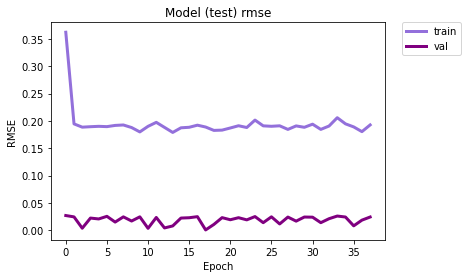

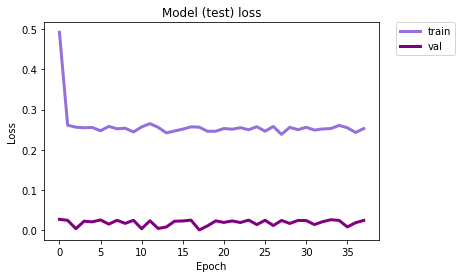

Epoch 1/300
5/5 [==============================] - 1s 170ms/step - loss: 0.2250 - mae: 0.1374 - rmse: 0.2340 - val_loss: 0.5859 - val_mae: 0.3340 - val_rmse: 0.5859
Epoch 2/300
5/5 [==============================] - 0s 93ms/step - loss: 0.2304 - mae: 0.1406 - rmse: 0.2390 - val_loss: 0.5812 - val_mae: 0.3295 - val_rmse: 0.5812
Epoch 3/300
5/5 [==============================] - 1s 124ms/step - loss: 0.2298 - mae: 0.1419 - rmse: 0.2317 - val_loss: 0.5769 - val_mae: 0.3252 - val_rmse: 0.5769
Epoch 4/300
5/5 [==============================] - 0s 69ms/step - loss: 0.2280 - mae: 0.1476 - rmse: 0.2371 - val_loss: 0.5757 - val_mae: 0.3240 - val_rmse: 0.5757
Epoch 5/300
5/5 [==============================] - 0s 64ms/step - loss: 0.2334 - mae: 0.1517 - rmse: 0.2387 - val_loss: 0.5756 - val_mae: 0.3237 - val_rmse: 0.5756
Epoch 6/300
5/5 [==============================] - 0s 62ms/step - loss: 0.2286 - mae: 0.1456 - rmse: 0.2291 - val_loss: 0.5724 - val_mae: 0.3212 - val_rmse: 0.5724
Epoch 7/300
5/

Epoch 51/300
5/5 [==============================] - 0s 63ms/step - loss: 0.2151 - mae: 0.1347 - rmse: 0.2206 - val_loss: 0.5597 - val_mae: 0.2870 - val_rmse: 0.5597
Epoch 52/300
5/5 [==============================] - 0s 65ms/step - loss: 0.2222 - mae: 0.1399 - rmse: 0.2280 - val_loss: 0.5599 - val_mae: 0.2866 - val_rmse: 0.5599
Epoch 53/300
5/5 [==============================] - 0s 69ms/step - loss: 0.2131 - mae: 0.1358 - rmse: 0.2155 - val_loss: 0.5593 - val_mae: 0.2849 - val_rmse: 0.5593
Epoch 54/300
5/5 [==============================] - 0s 73ms/step - loss: 0.2197 - mae: 0.1399 - rmse: 0.2134 - val_loss: 0.5628 - val_mae: 0.2888 - val_rmse: 0.5628
Epoch 55/300
5/5 [==============================] - 0s 69ms/step - loss: 0.2226 - mae: 0.1391 - rmse: 0.2254 - val_loss: 0.5601 - val_mae: 0.2841 - val_rmse: 0.5601
Epoch 56/300
5/5 [==============================] - 0s 68ms/step - loss: 0.2238 - mae: 0.1401 - rmse: 0.2270 - val_loss: 0.5587 - val_mae: 0.2810 - val_rmse: 0.5587
Epoch 57/3

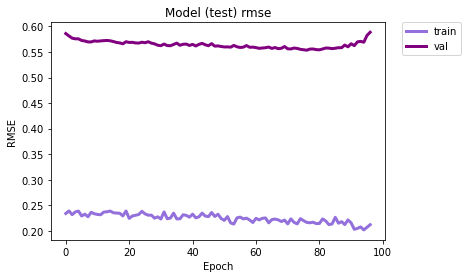

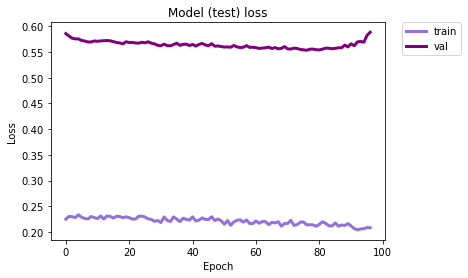

Epoch 1/300
7/7 [==============================] - 0s 73ms/step - loss: 0.2895 - mae: 0.1676 - rmse: 0.2911 - val_loss: 0.2885 - val_mae: 0.1779 - val_rmse: 0.1750
Epoch 2/300
7/7 [==============================] - 0s 67ms/step - loss: 0.2915 - mae: 0.1704 - rmse: 0.2950 - val_loss: 0.2863 - val_mae: 0.1762 - val_rmse: 0.1744
Epoch 3/300
7/7 [==============================] - 0s 69ms/step - loss: 0.2902 - mae: 0.1749 - rmse: 0.2964 - val_loss: 0.2863 - val_mae: 0.1751 - val_rmse: 0.1732
Epoch 4/300
7/7 [==============================] - 0s 67ms/step - loss: 0.2854 - mae: 0.1668 - rmse: 0.2859 - val_loss: 0.2850 - val_mae: 0.1734 - val_rmse: 0.1722
Epoch 5/300
7/7 [==============================] - 0s 68ms/step - loss: 0.2894 - mae: 0.1710 - rmse: 0.2942 - val_loss: 0.2857 - val_mae: 0.1728 - val_rmse: 0.1713
Epoch 6/300
7/7 [==============================] - 0s 59ms/step - loss: 0.2888 - mae: 0.1671 - rmse: 0.2911 - val_loss: 0.2816 - val_mae: 0.1691 - val_rmse: 0.1706
Epoch 7/300
7/7 

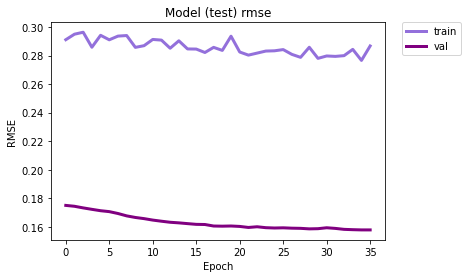

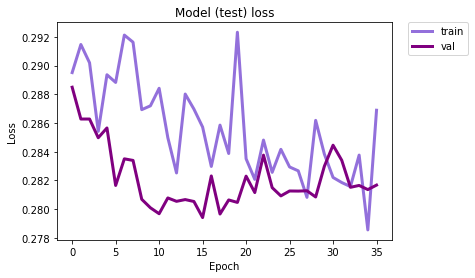

Epoch 1/300
9/9 [==============================] - 1s 98ms/step - loss: 0.2555 - mae: 0.1472 - rmse: 0.2405 - val_loss: 0.1838 - val_mae: 0.1040 - val_rmse: 0.2731
Epoch 2/300
9/9 [==============================] - 1s 85ms/step - loss: 0.2640 - mae: 0.1490 - rmse: 0.2480 - val_loss: 0.1838 - val_mae: 0.1019 - val_rmse: 0.2735
Epoch 3/300
9/9 [==============================] - 1s 102ms/step - loss: 0.2598 - mae: 0.1459 - rmse: 0.2450 - val_loss: 0.1838 - val_mae: 0.1010 - val_rmse: 0.2737
Epoch 4/300
9/9 [==============================] - 1s 93ms/step - loss: 0.2588 - mae: 0.1451 - rmse: 0.2428 - val_loss: 0.1840 - val_mae: 0.1002 - val_rmse: 0.2741
Epoch 5/300
9/9 [==============================] - 1s 147ms/step - loss: 0.2614 - mae: 0.1456 - rmse: 0.2456 - val_loss: 0.1838 - val_mae: 0.1005 - val_rmse: 0.2738
Epoch 6/300
9/9 [==============================] - 1s 114ms/step - loss: 0.2618 - mae: 0.1483 - rmse: 0.2452 - val_loss: 0.1837 - val_mae: 0.1010 - val_rmse: 0.2735
Epoch 7/300
9

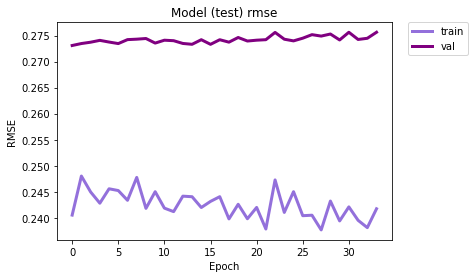

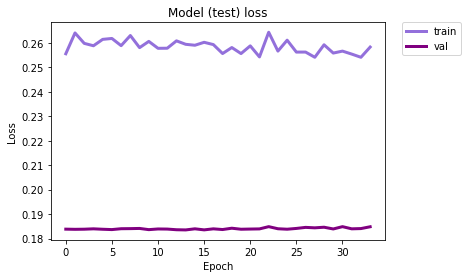

Epoch 1/300
11/11 [==============================] - 1s 80ms/step - loss: 0.2494 - mae: 0.1386 - rmse: 0.2439 - val_loss: 0.4359 - val_mae: 0.2360 - val_rmse: 0.4466
Epoch 2/300
11/11 [==============================] - 1s 64ms/step - loss: 0.2490 - mae: 0.1343 - rmse: 0.2428 - val_loss: 0.4345 - val_mae: 0.2376 - val_rmse: 0.4458
Epoch 3/300
11/11 [==============================] - 1s 68ms/step - loss: 0.2521 - mae: 0.1371 - rmse: 0.2452 - val_loss: 0.4346 - val_mae: 0.2382 - val_rmse: 0.4462
Epoch 4/300
11/11 [==============================] - 1s 73ms/step - loss: 0.2525 - mae: 0.1402 - rmse: 0.2456 - val_loss: 0.4351 - val_mae: 0.2388 - val_rmse: 0.4468
Epoch 5/300
11/11 [==============================] - 1s 79ms/step - loss: 0.2497 - mae: 0.1340 - rmse: 0.2436 - val_loss: 0.4350 - val_mae: 0.2410 - val_rmse: 0.4471
Epoch 6/300
11/11 [==============================] - 1s 67ms/step - loss: 0.2487 - mae: 0.1336 - rmse: 0.2403 - val_loss: 0.4349 - val_mae: 0.2389 - val_rmse: 0.4467
Epoc

11/11 [==============================] - 1s 78ms/step - loss: 0.2475 - mae: 0.1359 - rmse: 0.2388 - val_loss: 0.4281 - val_mae: 0.2288 - val_rmse: 0.4406
Epoch 51/300
11/11 [==============================] - 1s 79ms/step - loss: 0.2471 - mae: 0.1336 - rmse: 0.2381 - val_loss: 0.4279 - val_mae: 0.2283 - val_rmse: 0.4403
Epoch 52/300
11/11 [==============================] - 1s 83ms/step - loss: 0.2470 - mae: 0.1321 - rmse: 0.2382 - val_loss: 0.4278 - val_mae: 0.2307 - val_rmse: 0.4407
Epoch 53/300
11/11 [==============================] - 1s 70ms/step - loss: 0.2458 - mae: 0.1336 - rmse: 0.2387 - val_loss: 0.4275 - val_mae: 0.2275 - val_rmse: 0.4399
Epoch 54/300
11/11 [==============================] - 1s 67ms/step - loss: 0.2451 - mae: 0.1310 - rmse: 0.2358 - val_loss: 0.4283 - val_mae: 0.2300 - val_rmse: 0.4411
Epoch 55/300
11/11 [==============================] - 1s 64ms/step - loss: 0.2464 - mae: 0.1337 - rmse: 0.2387 - val_loss: 0.4276 - val_mae: 0.2284 - val_rmse: 0.4401
Epoch 56/30

11/11 [==============================] - 1s 87ms/step - loss: 0.2426 - mae: 0.1292 - rmse: 0.2338 - val_loss: 0.4220 - val_mae: 0.2241 - val_rmse: 0.4346
Epoch 100/300
11/11 [==============================] - 1s 88ms/step - loss: 0.2442 - mae: 0.1331 - rmse: 0.2383 - val_loss: 0.4216 - val_mae: 0.2231 - val_rmse: 0.4340
Epoch 101/300
11/11 [==============================] - 1s 99ms/step - loss: 0.2424 - mae: 0.1315 - rmse: 0.2335 - val_loss: 0.4220 - val_mae: 0.2231 - val_rmse: 0.4344
Epoch 102/300
11/11 [==============================] - 1s 96ms/step - loss: 0.2427 - mae: 0.1303 - rmse: 0.2346 - val_loss: 0.4221 - val_mae: 0.2231 - val_rmse: 0.4344
Epoch 103/300
11/11 [==============================] - 1s 88ms/step - loss: 0.2448 - mae: 0.1328 - rmse: 0.2365 - val_loss: 0.4226 - val_mae: 0.2237 - val_rmse: 0.4350
Epoch 104/300
11/11 [==============================] - 1s 94ms/step - loss: 0.2425 - mae: 0.1296 - rmse: 0.2326 - val_loss: 0.4219 - val_mae: 0.2242 - val_rmse: 0.4346
Epoch 

Epoch 148/300
11/11 [==============================] - 1s 113ms/step - loss: 0.2410 - mae: 0.1271 - rmse: 0.2324 - val_loss: 0.4189 - val_mae: 0.2218 - val_rmse: 0.4312
Epoch 149/300
11/11 [==============================] - 1s 112ms/step - loss: 0.2437 - mae: 0.1297 - rmse: 0.2337 - val_loss: 0.4143 - val_mae: 0.2244 - val_rmse: 0.4276
Epoch 150/300
11/11 [==============================] - 1s 94ms/step - loss: 0.2425 - mae: 0.1332 - rmse: 0.2361 - val_loss: 0.4154 - val_mae: 0.2189 - val_rmse: 0.4277
Epoch 151/300
11/11 [==============================] - 1s 90ms/step - loss: 0.2384 - mae: 0.1250 - rmse: 0.2288 - val_loss: 0.4163 - val_mae: 0.2211 - val_rmse: 0.4291
Epoch 152/300
11/11 [==============================] - 1s 90ms/step - loss: 0.2416 - mae: 0.1295 - rmse: 0.2346 - val_loss: 0.4176 - val_mae: 0.2207 - val_rmse: 0.4299
Epoch 153/300
11/11 [==============================] - 1s 92ms/step - loss: 0.2421 - mae: 0.1290 - rmse: 0.2315 - val_loss: 0.4126 - val_mae: 0.2192 - val_rms

Epoch 197/300
11/11 [==============================] - 1s 88ms/step - loss: 0.2299 - mae: 0.1259 - rmse: 0.2202 - val_loss: 0.3988 - val_mae: 0.2154 - val_rmse: 0.4110
Epoch 198/300
11/11 [==============================] - 1s 85ms/step - loss: 0.2287 - mae: 0.1200 - rmse: 0.2183 - val_loss: 0.3899 - val_mae: 0.2121 - val_rmse: 0.4037
Epoch 199/300
11/11 [==============================] - 1s 88ms/step - loss: 0.2329 - mae: 0.1274 - rmse: 0.2217 - val_loss: 0.3888 - val_mae: 0.2067 - val_rmse: 0.4009
Epoch 200/300
11/11 [==============================] - 1s 93ms/step - loss: 0.2313 - mae: 0.1255 - rmse: 0.2202 - val_loss: 0.3920 - val_mae: 0.2065 - val_rmse: 0.4045
Epoch 201/300
11/11 [==============================] - 1s 77ms/step - loss: 0.2258 - mae: 0.1204 - rmse: 0.2150 - val_loss: 0.4055 - val_mae: 0.2197 - val_rmse: 0.4171
Epoch 202/300
11/11 [==============================] - 1s 83ms/step - loss: 0.2400 - mae: 0.1276 - rmse: 0.2316 - val_loss: 0.3885 - val_mae: 0.2068 - val_rmse:

Epoch 246/300
11/11 [==============================] - 1s 88ms/step - loss: 0.2292 - mae: 0.1270 - rmse: 0.2224 - val_loss: 0.3930 - val_mae: 0.2208 - val_rmse: 0.4049
Epoch 247/300
11/11 [==============================] - 1s 92ms/step - loss: 0.2314 - mae: 0.1258 - rmse: 0.2207 - val_loss: 0.3802 - val_mae: 0.2042 - val_rmse: 0.3930
Epoch 248/300
11/11 [==============================] - 1s 94ms/step - loss: 0.2286 - mae: 0.1246 - rmse: 0.2193 - val_loss: 0.3945 - val_mae: 0.2225 - val_rmse: 0.4058
Epoch 249/300
11/11 [==============================] - 1s 89ms/step - loss: 0.2263 - mae: 0.1259 - rmse: 0.2174 - val_loss: 0.3865 - val_mae: 0.2184 - val_rmse: 0.3990
Epoch 250/300
11/11 [==============================] - 1s 84ms/step - loss: 0.2226 - mae: 0.1223 - rmse: 0.2133 - val_loss: 0.3962 - val_mae: 0.2273 - val_rmse: 0.4080
Epoch 251/300
11/11 [==============================] - 1s 87ms/step - loss: 0.2327 - mae: 0.1314 - rmse: 0.2223 - val_loss: 0.3855 - val_mae: 0.2155 - val_rmse:

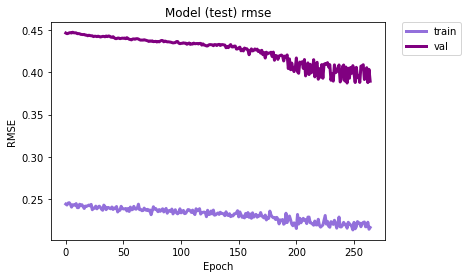

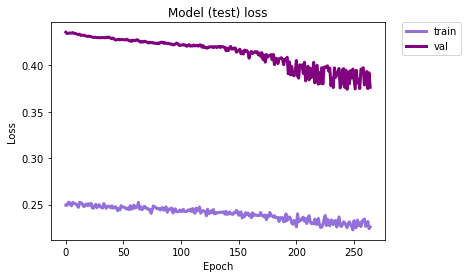

In [16]:
# fitting the model
modelTime = build_model(TIMESTEPS, FEATURES, name = 'test')
modelTime, hist_list, loss_list = compile_and_fit(modelTime, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat -0.87842506
Transformed yhat 22.795471
yhat -0.852448
Transformed yhat 23.088713
yhat -0.8428809
Transformed yhat 23.19671
yhat -0.84156734
Transformed yhat 23.211536
yhat -0.8353776
Transformed yhat 23.28141
yhat -0.81605196
Transformed yhat 23.499569
yhat -0.7855103
Transformed yhat 23.844336
yhat -0.75903374
Transformed yhat 24.143213
yhat -0.84586155
Transformed yhat 23.163063
yhat -0.8835203
Transformed yhat 22.737953
yhat -0.89646536
Transformed yhat 22.591822
yhat -0.9077908
Transformed yhat 22.463976
Real data: [23.87890402 22.24973125 23.50619014 25.3934313  24.61284404 26.9260605
 27.40274439 34.77985684 25.95459081 22.39454661 21.42307692 21.42307692
 21.42307692 24.45213148 22.7807209  21.42307692 21.42307692 21.42307692
 21.42307692 21.42307692 21.42307692 21.48945063 24.68142246 23.80800484]
Forecasting values: [22.8, 23.1, 23.2, 23.2, 23.3, 23.5, 23.8, 24.1, 23.2, 22.7, 22.6, 22.5]


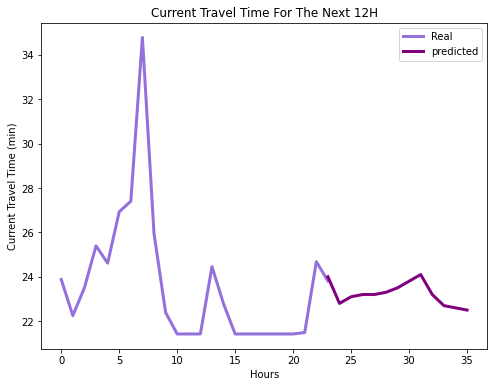

In [17]:
# Recursive Multi-step Forecast
forecasts = forecast(modelTime,normalized_Time, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction(normalized_Time, forecasts, scaler)

In [18]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)

In [19]:
import csv

with open('predictionsTime.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'N103.0',forecasts[i],hour[i]
        writer.writerow(d)

# LSTM - Speed

In [20]:
# our supervised problem
x, y = to_supervised(normalized_Speed, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 14s 1s/step - loss: 0.6627 - mae: 0.5948 - rmse: 0.5903 - val_loss: 0.0866 - val_mae: 0.0866 - val_rmse: 0.0866
Epoch 2/300
3/3 [==============================] - 0s 130ms/step - loss: 0.5743 - mae: 0.3701 - rmse: 0.5087 - val_loss: 0.1314 - val_mae: 0.1314 - val_rmse: 0.1314
Epoch 3/300
3/3 [==============================] - 0s 211ms/step - loss: 0.5657 - mae: 0.4908 - rmse: 0.4998 - val_loss: 0.0489 - val_mae: 0.0489 - val_rmse: 0.0489
Epoch 4/300
3/3 [==============================] - 0s 146ms/step - loss: 0.5217 - mae: 0.3786 - rmse: 0.4623 - val_loss: 0.0316 - val_mae: 0.0316 - val_rmse: 0.0316
Epoch 5/300
3/3 [==============================] - 0s 133ms/step - loss: 0.5207 - mae: 0.3879 - rmse: 0.4601 - val_loss: 0.0444 - val_mae: 0.0444 - val_rmse: 0.0444
Epoch 6/300
3/3 [==============================] - 0s 112ms/step - loss: 0.5299 - mae: 0.3845 - rmse: 0.4739 - val_loss: 0.0706 - val_mae: 0.0706 - val_rmse: 0.0706
Epoch 7/300


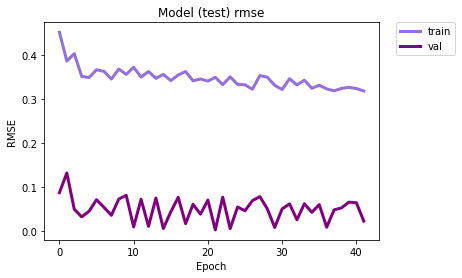

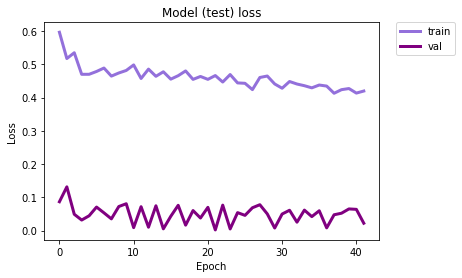

Epoch 1/300
5/5 [==============================] - 0s 102ms/step - loss: 0.3709 - mae: 0.2555 - rmse: 0.3877 - val_loss: 0.6672 - val_mae: 0.4417 - val_rmse: 0.6672
Epoch 2/300
5/5 [==============================] - 0s 92ms/step - loss: 0.3837 - mae: 0.2636 - rmse: 0.3952 - val_loss: 0.6645 - val_mae: 0.4386 - val_rmse: 0.6645
Epoch 3/300
5/5 [==============================] - 0s 92ms/step - loss: 0.3783 - mae: 0.2618 - rmse: 0.3943 - val_loss: 0.6598 - val_mae: 0.4341 - val_rmse: 0.6598
Epoch 4/300
5/5 [==============================] - 0s 80ms/step - loss: 0.3862 - mae: 0.2663 - rmse: 0.4044 - val_loss: 0.6589 - val_mae: 0.4324 - val_rmse: 0.6589
Epoch 5/300
5/5 [==============================] - 0s 92ms/step - loss: 0.3741 - mae: 0.2593 - rmse: 0.3932 - val_loss: 0.6563 - val_mae: 0.4297 - val_rmse: 0.6563
Epoch 6/300
5/5 [==============================] - 0s 96ms/step - loss: 0.3823 - mae: 0.2635 - rmse: 0.3965 - val_loss: 0.6550 - val_mae: 0.4271 - val_rmse: 0.6550
Epoch 7/300
5/5

5/5 [==============================] - 0s 100ms/step - loss: 0.3646 - mae: 0.2450 - rmse: 0.3745 - val_loss: 0.6390 - val_mae: 0.4151 - val_rmse: 0.6390
Epoch 51/300
5/5 [==============================] - 0s 93ms/step - loss: 0.3599 - mae: 0.2427 - rmse: 0.3669 - val_loss: 0.6369 - val_mae: 0.4147 - val_rmse: 0.6369
Epoch 52/300
5/5 [==============================] - 0s 101ms/step - loss: 0.3709 - mae: 0.2422 - rmse: 0.3811 - val_loss: 0.6333 - val_mae: 0.4135 - val_rmse: 0.6333
Epoch 53/300
5/5 [==============================] - 0s 100ms/step - loss: 0.3639 - mae: 0.2444 - rmse: 0.3687 - val_loss: 0.6363 - val_mae: 0.4149 - val_rmse: 0.6363
Epoch 54/300
5/5 [==============================] - 0s 104ms/step - loss: 0.3652 - mae: 0.2450 - rmse: 0.3679 - val_loss: 0.6338 - val_mae: 0.4147 - val_rmse: 0.6338
Epoch 55/300
5/5 [==============================] - 0s 89ms/step - loss: 0.3628 - mae: 0.2382 - rmse: 0.3642 - val_loss: 0.6330 - val_mae: 0.4152 - val_rmse: 0.6330
Epoch 56/300
5/5 [=

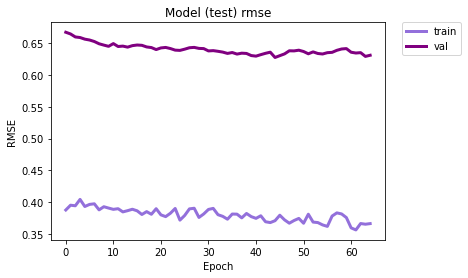

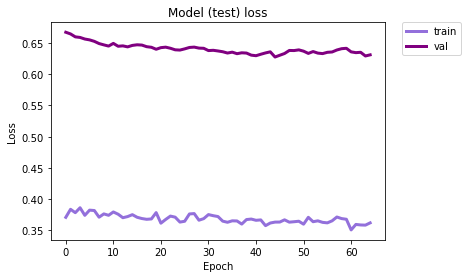

Epoch 1/300
7/7 [==============================] - 1s 113ms/step - loss: 0.4226 - mae: 0.2844 - rmse: 0.4358 - val_loss: 0.4643 - val_mae: 0.3249 - val_rmse: 0.2771
Epoch 2/300
7/7 [==============================] - 1s 115ms/step - loss: 0.4275 - mae: 0.2942 - rmse: 0.4424 - val_loss: 0.4624 - val_mae: 0.3255 - val_rmse: 0.2768
Epoch 3/300
7/7 [==============================] - 1s 118ms/step - loss: 0.4364 - mae: 0.3024 - rmse: 0.4515 - val_loss: 0.4595 - val_mae: 0.3267 - val_rmse: 0.2766
Epoch 4/300
7/7 [==============================] - 1s 152ms/step - loss: 0.4198 - mae: 0.2927 - rmse: 0.4326 - val_loss: 0.4571 - val_mae: 0.3275 - val_rmse: 0.2763
Epoch 5/300
7/7 [==============================] - 1s 170ms/step - loss: 0.4310 - mae: 0.3035 - rmse: 0.4511 - val_loss: 0.4595 - val_mae: 0.3264 - val_rmse: 0.2770
Epoch 6/300
7/7 [==============================] - 1s 183ms/step - loss: 0.4306 - mae: 0.3056 - rmse: 0.4502 - val_loss: 0.4589 - val_mae: 0.3267 - val_rmse: 0.2772
Epoch 7/30

7/7 [==============================] - 1s 92ms/step - loss: 0.4134 - mae: 0.2793 - rmse: 0.4228 - val_loss: 0.4287 - val_mae: 0.2876 - val_rmse: 0.2484
Epoch 51/300
7/7 [==============================] - 1s 110ms/step - loss: 0.4072 - mae: 0.2754 - rmse: 0.4176 - val_loss: 0.4281 - val_mae: 0.2852 - val_rmse: 0.2466
Epoch 52/300
7/7 [==============================] - 1s 123ms/step - loss: 0.4097 - mae: 0.2733 - rmse: 0.4216 - val_loss: 0.4267 - val_mae: 0.2827 - val_rmse: 0.2453
Epoch 53/300
7/7 [==============================] - 1s 118ms/step - loss: 0.4134 - mae: 0.2757 - rmse: 0.4303 - val_loss: 0.4270 - val_mae: 0.2814 - val_rmse: 0.2457
Epoch 54/300
7/7 [==============================] - 1s 113ms/step - loss: 0.4048 - mae: 0.2652 - rmse: 0.4224 - val_loss: 0.4262 - val_mae: 0.2801 - val_rmse: 0.2449
Epoch 55/300
7/7 [==============================] - 1s 96ms/step - loss: 0.4054 - mae: 0.2707 - rmse: 0.4154 - val_loss: 0.4263 - val_mae: 0.2772 - val_rmse: 0.2446
Epoch 56/300
7/7 [=

7/7 [==============================] - 1s 143ms/step - loss: 0.3839 - mae: 0.2427 - rmse: 0.3832 - val_loss: 0.3999 - val_mae: 0.2283 - val_rmse: 0.2268
Epoch 100/300
7/7 [==============================] - 1s 122ms/step - loss: 0.3969 - mae: 0.2530 - rmse: 0.4090 - val_loss: 0.4031 - val_mae: 0.2361 - val_rmse: 0.2282
Epoch 101/300
7/7 [==============================] - 1s 98ms/step - loss: 0.3855 - mae: 0.2409 - rmse: 0.3938 - val_loss: 0.3988 - val_mae: 0.2298 - val_rmse: 0.2259
Epoch 102/300
7/7 [==============================] - 1s 90ms/step - loss: 0.3943 - mae: 0.2495 - rmse: 0.3930 - val_loss: 0.3987 - val_mae: 0.2302 - val_rmse: 0.2267
Epoch 103/300
7/7 [==============================] - 1s 134ms/step - loss: 0.3953 - mae: 0.2461 - rmse: 0.4006 - val_loss: 0.3990 - val_mae: 0.2297 - val_rmse: 0.2270
Epoch 104/300
7/7 [==============================] - 1s 134ms/step - loss: 0.3889 - mae: 0.2460 - rmse: 0.3982 - val_loss: 0.4006 - val_mae: 0.2310 - val_rmse: 0.2284
Epoch 105/300


7/7 [==============================] - 1s 131ms/step - loss: 0.3830 - mae: 0.2508 - rmse: 0.3935 - val_loss: 0.3865 - val_mae: 0.2170 - val_rmse: 0.2244
Epoch 149/300
7/7 [==============================] - 1s 143ms/step - loss: 0.3618 - mae: 0.2329 - rmse: 0.3576 - val_loss: 0.3771 - val_mae: 0.2085 - val_rmse: 0.2163
Epoch 150/300
7/7 [==============================] - 1s 116ms/step - loss: 0.3701 - mae: 0.2353 - rmse: 0.3732 - val_loss: 0.3798 - val_mae: 0.2083 - val_rmse: 0.2195
Epoch 151/300
7/7 [==============================] - 1s 116ms/step - loss: 0.3768 - mae: 0.2378 - rmse: 0.3738 - val_loss: 0.3765 - val_mae: 0.2064 - val_rmse: 0.2172
Epoch 152/300
7/7 [==============================] - 1s 115ms/step - loss: 0.3685 - mae: 0.2294 - rmse: 0.3748 - val_loss: 0.3761 - val_mae: 0.2097 - val_rmse: 0.2174
Epoch 153/300
7/7 [==============================] - 1s 129ms/step - loss: 0.3665 - mae: 0.2381 - rmse: 0.3594 - val_loss: 0.3767 - val_mae: 0.2043 - val_rmse: 0.2178
Epoch 154/30

7/7 [==============================] - 1s 119ms/step - loss: 0.3652 - mae: 0.2322 - rmse: 0.3650 - val_loss: 0.3583 - val_mae: 0.1943 - val_rmse: 0.2093
Epoch 198/300
7/7 [==============================] - 1s 119ms/step - loss: 0.3586 - mae: 0.2345 - rmse: 0.3616 - val_loss: 0.3613 - val_mae: 0.1973 - val_rmse: 0.2098
Epoch 199/300
7/7 [==============================] - 1s 111ms/step - loss: 0.3497 - mae: 0.2279 - rmse: 0.3385 - val_loss: 0.3627 - val_mae: 0.1976 - val_rmse: 0.2095
Epoch 200/300
7/7 [==============================] - 1s 105ms/step - loss: 0.3468 - mae: 0.2242 - rmse: 0.3634 - val_loss: 0.3556 - val_mae: 0.1902 - val_rmse: 0.2056
Epoch 201/300
7/7 [==============================] - 1s 107ms/step - loss: 0.3571 - mae: 0.2349 - rmse: 0.3581 - val_loss: 0.3559 - val_mae: 0.1905 - val_rmse: 0.2054
Epoch 202/300
7/7 [==============================] - 1s 109ms/step - loss: 0.3539 - mae: 0.2299 - rmse: 0.3538 - val_loss: 0.3559 - val_mae: 0.1876 - val_rmse: 0.2035
Epoch 203/30

7/7 [==============================] - 1s 111ms/step - loss: 0.3388 - mae: 0.2236 - rmse: 0.3258 - val_loss: 0.3472 - val_mae: 0.1764 - val_rmse: 0.1962
Epoch 247/300
7/7 [==============================] - 1s 122ms/step - loss: 0.3409 - mae: 0.2189 - rmse: 0.3322 - val_loss: 0.3532 - val_mae: 0.1969 - val_rmse: 0.1982
Epoch 248/300
7/7 [==============================] - 1s 114ms/step - loss: 0.3318 - mae: 0.2141 - rmse: 0.3219 - val_loss: 0.3511 - val_mae: 0.1892 - val_rmse: 0.1966
Epoch 249/300
7/7 [==============================] - 1s 98ms/step - loss: 0.3480 - mae: 0.2228 - rmse: 0.3468 - val_loss: 0.3475 - val_mae: 0.1870 - val_rmse: 0.1951
Epoch 250/300
7/7 [==============================] - 1s 92ms/step - loss: 0.3518 - mae: 0.2246 - rmse: 0.3543 - val_loss: 0.3457 - val_mae: 0.1795 - val_rmse: 0.1941
Epoch 251/300
7/7 [==============================] - 1s 171ms/step - loss: 0.3472 - mae: 0.2232 - rmse: 0.3393 - val_loss: 0.3460 - val_mae: 0.1780 - val_rmse: 0.1941
Epoch 252/300


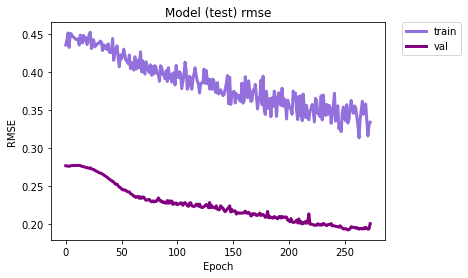

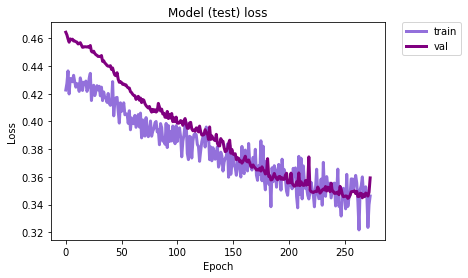

Epoch 1/300
9/9 [==============================] - 2s 199ms/step - loss: 0.3313 - mae: 0.2119 - rmse: 0.3175 - val_loss: 0.2860 - val_mae: 0.1789 - val_rmse: 0.4052
Epoch 2/300
9/9 [==============================] - 1s 169ms/step - loss: 0.3388 - mae: 0.2223 - rmse: 0.3202 - val_loss: 0.2848 - val_mae: 0.1774 - val_rmse: 0.4044
Epoch 3/300
9/9 [==============================] - ETA: 0s - loss: 0.3365 - mae: 0.2150 - rmse: 0.32 - 1s 138ms/step - loss: 0.3365 - mae: 0.2150 - rmse: 0.3215 - val_loss: 0.2866 - val_mae: 0.1800 - val_rmse: 0.4067
Epoch 4/300
9/9 [==============================] - 1s 127ms/step - loss: 0.3303 - mae: 0.2163 - rmse: 0.3163 - val_loss: 0.2827 - val_mae: 0.1789 - val_rmse: 0.4014
Epoch 5/300
9/9 [==============================] - 1s 144ms/step - loss: 0.3296 - mae: 0.2143 - rmse: 0.3118 - val_loss: 0.2783 - val_mae: 0.1763 - val_rmse: 0.3950
Epoch 6/300
9/9 [==============================] - 1s 169ms/step - loss: 0.3275 - mae: 0.2168 - rmse: 0.3149 - val_loss: 0.

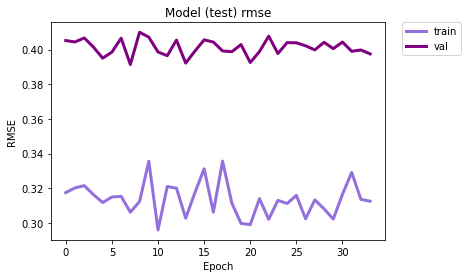

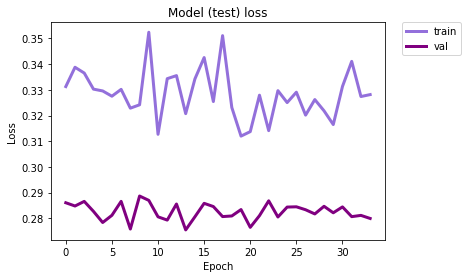

Epoch 1/300
11/11 [==============================] - 1s 100ms/step - loss: 0.3278 - mae: 0.2073 - rmse: 0.3261 - val_loss: 0.4840 - val_mae: 0.3368 - val_rmse: 0.4930
Epoch 2/300
11/11 [==============================] - 1s 89ms/step - loss: 0.3193 - mae: 0.2007 - rmse: 0.3083 - val_loss: 0.4941 - val_mae: 0.3467 - val_rmse: 0.5028
Epoch 3/300
11/11 [==============================] - 1s 90ms/step - loss: 0.3176 - mae: 0.2024 - rmse: 0.3048 - val_loss: 0.4852 - val_mae: 0.3396 - val_rmse: 0.4941
Epoch 4/300
11/11 [==============================] - 1s 90ms/step - loss: 0.3216 - mae: 0.2043 - rmse: 0.3149 - val_loss: 0.4989 - val_mae: 0.3536 - val_rmse: 0.5075
Epoch 5/300
11/11 [==============================] - 1s 92ms/step - loss: 0.3270 - mae: 0.2035 - rmse: 0.3129 - val_loss: 0.4704 - val_mae: 0.3263 - val_rmse: 0.4798
Epoch 6/300
11/11 [==============================] - 1s 86ms/step - loss: 0.3279 - mae: 0.2079 - rmse: 0.3244 - val_loss: 0.4783 - val_mae: 0.3361 - val_rmse: 0.4876
Epo

11/11 [==============================] - 1s 85ms/step - loss: 0.3190 - mae: 0.2053 - rmse: 0.3121 - val_loss: 0.4649 - val_mae: 0.3240 - val_rmse: 0.4743
Epoch 51/300
11/11 [==============================] - 1s 86ms/step - loss: 0.3131 - mae: 0.1957 - rmse: 0.3040 - val_loss: 0.4657 - val_mae: 0.3239 - val_rmse: 0.4750
Epoch 52/300
11/11 [==============================] - 1s 96ms/step - loss: 0.3110 - mae: 0.1947 - rmse: 0.3044 - val_loss: 0.4885 - val_mae: 0.3468 - val_rmse: 0.4968
Epoch 53/300
11/11 [==============================] - 1s 98ms/step - loss: 0.3245 - mae: 0.2065 - rmse: 0.3172 - val_loss: 0.4730 - val_mae: 0.3329 - val_rmse: 0.4817
Epoch 54/300
11/11 [==============================] - 1s 92ms/step - loss: 0.3185 - mae: 0.2030 - rmse: 0.3085 - val_loss: 0.4741 - val_mae: 0.3327 - val_rmse: 0.4829
Epoch 55/300
11/11 [==============================] - 1s 87ms/step - loss: 0.3116 - mae: 0.1951 - rmse: 0.3060 - val_loss: 0.4739 - val_mae: 0.3312 - val_rmse: 0.4829
Epoch 56/30

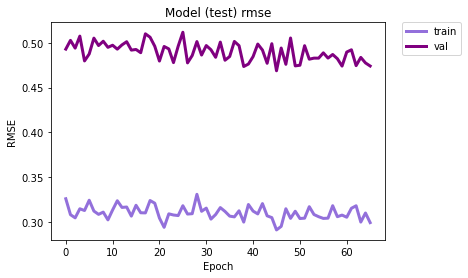

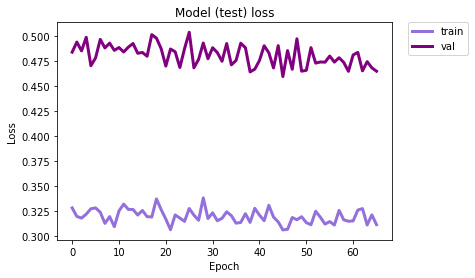

In [21]:
# fitting the model
modelSpeed = build_model(TIMESTEPS, FEATURES, name = 'test')
modelSpeed , hist_list, loss_list = compile_and_fit(modelSpeed, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat 0.6090193
Transformed yhat 39.58643
yhat 0.59217167
Transformed yhat 39.396248
yhat 0.5626405
Transformed yhat 39.062885
yhat 0.55072516
Transformed yhat 38.928375
yhat 0.5554105
Transformed yhat 38.98127
yhat 0.5323647
Transformed yhat 38.721115
yhat 0.5160958
Transformed yhat 38.537464
yhat 0.48647076
Transformed yhat 38.203045
yhat 0.55688846
Transformed yhat 38.99795
yhat 0.67647445
Transformed yhat 40.347893
yhat 0.75580066
Transformed yhat 41.243362
yhat 0.80856866
Transformed yhat 41.839035
Real data: [38.25490196 41.66666667 38.57692308 33.92156863 36.36538462 30.25490196
 30.43137255 21.42307692 32.21568627 41.41176471 44.         44.
 44.         36.90196078 40.43137255 44.         44.         44.
 44.         44.         44.         43.80392157 35.58823529 37.925     ]
Forecasting values: [39.6, 39.4, 39.1, 38.9, 39.0, 38.7, 38.5, 38.2, 39.0, 40.3, 41.2, 41.8]


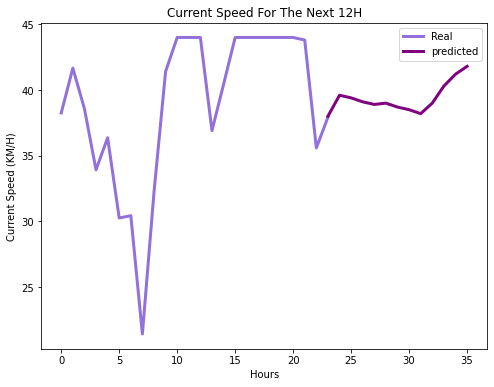

In [22]:
# Recursive Multi-step Forecast
forecastSpeed = forecast(modelSpeed,normalized_Speed, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction_Speed(normalized_Speed, forecastSpeed, scaler)

In [23]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)

In [24]:
import csv

with open('predictionsSpeed.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'N103.0',forecastSpeed[i],hour[i]
        writer.writerow(d)
